Before you begin, execute this cell to import numpy and packages from the D-Wave Ocean suite, and all necessary functions the gate-model framework you are going to use, whether that is the Forest SDK or Qiskit. In the case of Forest SDK, it also starts the qvm and quilc servers.

In [1]:
%run -i "assignment_helper.py"

Available frameworks:
Forest SDK
Qiskit
D-Wave Ocean


# Loss Functions and Regularization

Let's generate an easily, linearly separable dataset and shuffle it into a training set that we are going to optimize over (2/3 of the data), and a test set where we estimate our generalization performance. 

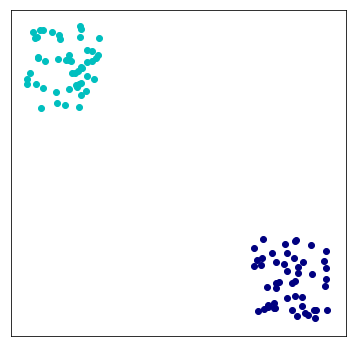

In [2]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)
%matplotlib inline

c1 = np.random.rand(50, 2)/5
c2 = (-0.6, 0.5) + np.random.rand(50, 2)/5
data = np.concatenate((c1, c2))
labels = np.array([0] * 50 + [1] *50)
plt.figure(figsize=(6, 6))
plt.subplot(111, xticks=[], yticks=[])
plt.scatter(data[:50, 0], data[:50, 1], color='navy')
plt.scatter(data[50:, 0], data[50:, 1], color='c')
idx = np.arange(len(labels))
np.random.shuffle(idx)
# train on a random 2/3 and test on the remaining 1/3
idx_train = idx[:2*len(idx)//3]
idx_test = idx[2*len(idx)//3:]
X_train = data[idx_train]
X_test = data[idx_test]
y_train = labels[idx_train]
y_test = labels[idx_test]

In [3]:
print(len(X_train))
print(len(X_test))

print(len(y_train))
print(len(y_test))

66
34
66
34


**Exercise 1** (1 point). A multilayer perceptron is a simple neural network that is composed of perceptrons arranged in layers, mapping from some high-dimensional space to a number of classes. In scikit-learn, it minimizes the cross-entropy $L(\theta, S) = -\frac {1}{N}\sum _{i=1}^N y_i \log h(\theta;x_i) + (1-y_i) \log(1-h(\theta;x_i))$, where our training set is $S=\{(x_i, y_i)\}_{i=1}^N$. Train one such network with default parameters. The model is called `MLPClassifier` in scikit-learn. Place the trained model in an object called `model`.

In [4]:
import sklearn
import sklearn.metrics
from sklearn.neural_network import MLPClassifier
metric = sklearn.metrics.accuracy_score
###
model_1 = MLPClassifier()
model_1.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_1.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_1.predict(X_test))))
###


accuracy (train):  1.00
accuracy (test):  1.00


/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [5]:
assert isinstance(model_1, sklearn.neural_network.MLPClassifier)
assert np.isclose(metric(y_train, model_1.predict(X_train)), 1.0)
assert np.isclose(metric(y_test, model_1.predict(X_test)), 1.0)

**Exercise 2** (2 points). The model can be regularized by an $l_2$ penalty term, which means that we can penalize it for having large weights in the connections between the perceptrons. For the model you trained, the sum of the square norms is the following:

In [6]:
sum(np.linalg.norm(coefs) for coefs in model_1.coefs_)

5.170631029132808

The strength of the normalization depends on a hyperparameter `alpha` that you can supply when you instantiate the class. Train a heavily regularized version that will have a lower $l_2$ norm for the weights that maintains the training and test accuracy. Place the trained model in an object called `model_2`.

In [7]:
###
model_2 = MLPClassifier(alpha=1e1)
model_2.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_2.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_2.predict(X_test))))
###
sum(np.linalg.norm(coefs) for coefs in model_2.coefs_)


accuracy (train):  1.00
accuracy (test):  1.00


/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2.184300675400768

In [8]:
assert isinstance(model_2, sklearn.neural_network.MLPClassifier)
assert np.isclose(metric(y_train, model_2.predict(X_train)), 1.0)
assert np.isclose(metric(y_test, model_2.predict(X_test)), 1.0)
assert abs(sum(np.linalg.norm(coefs) for coefs in model_1.coefs_)-
           sum(np.linalg.norm(coefs) for coefs in model_2.coefs_)) > 1

In principle, a sparser model (in this case, one with lower $l_2$ norm) provides better guarantees for generalization beyond the training dataset.

# Ensemble methods

Ensembles are all about combining diverse models into a single strong classifier. There are countless ways to construct ensembles. One way to ensure diversity is to train the same family of models, but on different subsets of the training data. This is known as [bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating) and it is a way of avoiding overfitting. You can combine bagging with other forms of ensembles to construct robust models.

**Exercise 3** (1 point). Random forests do bagging: the algorithm trains many simple decision trees on various subsets of the training data, then averages their output to make predictions. Train a random forest on the above data to maximum accuracy with 20 trees in the ensemble. Place the trained model in an object called `model_3`.

In [9]:
from sklearn.ensemble import RandomForestClassifier
###
model_3 = RandomForestClassifier(n_estimators=20)
model_3.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_3.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_3.predict(X_test))))
###


accuracy (train):  1.00
accuracy (test):  1.00


We generate a random dataset of two classes that form concentric circles:

In [10]:
assert isinstance(model_3, sklearn.ensemble.RandomForestClassifier)
assert model_3.n_estimators == 20
assert np.isclose(metric(y_train, model_3.predict(X_train)), 1.0)
assert np.isclose(metric(y_test, model_3.predict(X_test)), 1.0)

# QBoost

QBoost uses $l_0$ regularization to penalize the number of models in an ensemble and solves this as a discrete optimization problem. We will use the Swiss roll dataset in this section:

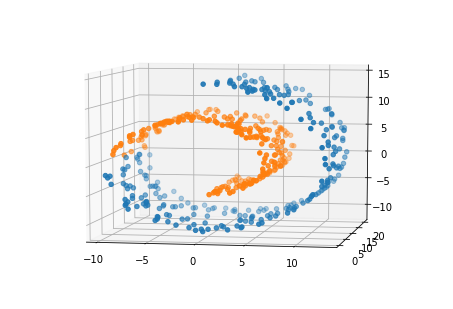

In [11]:
import mpl_toolkits.mplot3d.axes3d as p3
import sklearn.datasets
np.random.seed(0)
data, t = sklearn.datasets.make_swiss_roll(n_samples=500)
labels = np.array(t<t.mean())
idx = np.arange(len(labels))
np.random.shuffle(idx)
# train on a random 2/3 and test on the remaining 1/3
idx_train = idx[:2*len(idx)//3]
idx_test = idx[2*len(idx)//3:]
X_train = data[idx_train]
X_test = data[idx_test]

y_train = 2 * labels[idx_train] - 1  # binary -> spin
y_test = 2 * labels[idx_test] - 1

scaler = sklearn.preprocessing.StandardScaler()
normalizer = sklearn.preprocessing.Normalizer()

X_train = scaler.fit_transform(X_train)
X_train = normalizer.fit_transform(X_train)

X_test = scaler.fit_transform(X_test)
X_test = normalizer.fit_transform(X_test)
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(labels):
    ax.scatter(data[labels == l, 0], data[labels == l, 1], data[labels == l, 2])

**Exercise 4** (1 point). Train a random forest of twenty trees on this dataset until you get accuracy 1 on the training set. You can ignore the accuracy on the test set. Call this `model_4`.

In [12]:
###
model_4 = RandomForestClassifier(n_estimators=20)
model_4.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_4.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_4.predict(X_test))))
###


accuracy (train):  0.98
accuracy (test):  0.81


In [13]:
assert isinstance(model_4, sklearn.ensemble.RandomForestClassifier)
assert model_4.n_estimators == 20
assert np.isclose(metric(y_train, model_4.predict(X_train)), 1.0, rtol=0.1)

Observe the gap between training and test accuracy:

In [14]:
metric(y_train, model_4.predict(X_train)) - metric(y_test, model_4.predict(X_test))

0.17359874844904777

**Exercise 5** (2 points). The random forest as you trained it gives you a hundred weak estimators. Create a function that takes a numpy array of predictions over all weak estimators, the true labels, and a $\lambda$ parameter for regularization, and returns a quadratic binary optimization of the QBoost objective function for dimod. Your return value is a weight matrix as a dictionary. You can assume that the prediction array's shape is the number of models times the number of training points.

In [15]:
def get_qubo(predictions, y, λ):
    
    # #of weak estimators:
    k = len(predictions)
    
    # #of X_train points:
    l = len(predictions[0])
    
    # scale hij to [-1/k, 1/k]
    #predictions = np.divide(predictions, k)
    ### 
    w = np.dot(predictions, predictions.T) 
    wii = l/(k ** 2) - 2 * np.dot(predictions, y) + λ
    print(wii)
    w[np.diag_indices_from(w)] = wii
    W = {}
    for i in range(k):
        for j in range(i, k):
            W[(i, j)] = w[i, j]
    
    return W

predictions_mytest = np.array([[-1,1],[-1,1]])
y_mytest = [-1,1]
λ = 1

k = len(predictions_mytest)
l = len(predictions_mytest[0])

g = np.dot(predictions_mytest, predictions_mytest.T)
gii = l//(k ** 2) - 2 * np.dot(predictions_mytest, y_mytest) + λ

print(g)
print(np.dot(predictions_mytest, y_mytest))
print(gii)


print(get_qubo(predictions_mytest, y_mytest, 1))
print(get_qubo(predictions_mytest, y_mytest, 10))
###

[[2 2]
 [2 2]]
[2 2]
[-3 -3]
[-2.5 -2.5]
{(0, 0): -2, (0, 1): 2, (1, 1): -2}
[6.5 6.5]
{(0, 0): 6, (0, 1): 2, (1, 1): 6}


In [16]:
predictions = np.array([[-1, 1], [-1, 1]])
y = [-1, 1]
assert get_qubo(predictions, y, 1) == {(0, 0): -2, (0, 1): 2, (1, 1): -2}
assert get_qubo(predictions, y, 10) == {(0, 0): 6, (0, 1): 2, (1, 1): 6}

[-2.5 -2.5]
[6.5 6.5]


Note that the random forest model always predicts 0 or 1 for the individiual weak estimators, so we shift its prediction output to match our spin model.

In [17]:
predictions = 2*np.array([h.predict(X_train) for h in model_4.estimators_], dtype=np.float64)-1
predictions

array([[ 1., -1.,  1., ..., -1.,  1., -1.],
       [ 1., -1.,  1., ..., -1.,  1., -1.],
       [ 1.,  1.,  1., ..., -1.,  1., -1.],
       ...,
       [ 1., -1.,  1., ..., -1.,  1., -1.],
       [ 1.,  1.,  1., ..., -1.,  1., -1.],
       [ 1., -1.,  1., ..., -1.,  1., -1.]])

In [18]:
print(len(predictions))
print(len(predictions[0]))

20
333


**Exercise 6** (3 points). Using simulated annealing, find a value for the $\lambda$ parameter that reduces the number of trees used while maintaining the accuracy on the training set. The return value of the sampler should be in an object called `response`. You can use the following function to calculate the prediction of your ensemble:

In [19]:
def predict(models, weights, X):
    n_data = len(X)
    T = 0
    y = np.zeros(n_data)
    for i, h in enumerate(models):
        y0 = weights[i] * (2*h.predict(X)-1)  # prediction of weak classifier
        y += y0
        T += np.sum(y0)
    y = np.sign(y - T / (n_data*len(models)))
    return y

In [ ]:
###
import dimod

def modifying(predictions):
    
    λ = 1e-2
    while(λ < 1e1):
        W = get_qubo(predictions, y_train, λ)
        sampler = dimod.SimulatedAnnealingSampler()
        response = sampler.sample_qubo(W, num_reads=10)
        weights = list(response.first.sample.values())
        λ += .01
        if np.isclose(metric(y_train, predict(model_4.estimators_,
        weights, X_train)), 1.0, rtol=0.01) and sum(weights)<20:
            break 
    
    return response, weights

predictions = np.divide(predictions, len(predictions))

response, weights = modifying(predictions)
#print(response)

#print(sum(weights))
#print('accuracy (train): %5.2f'%(metric(y_train, predict(model_4.estimators_, weights, X_train))))
#print('accuracy (test): %5.2f'%(metric(y_test, predict(model_4.estimators_, weights, X_test))))

###


[0.84232938 0.84233438 0.84232563 0.84232063 0.84233563 0.84233563
 0.84234813 0.84234688 0.84233938 0.84232938 0.84233062 0.84233188
 0.84233687 0.84234688 0.84232438 0.84235063 0.84233687 0.84232812
 0.84233313 0.84233438]
[0.85232938 0.85233438 0.85232563 0.85232063 0.85233563 0.85233563
 0.85234813 0.85234688 0.85233938 0.85232938 0.85233063 0.85233188
 0.85233687 0.85234688 0.85232438 0.85235063 0.85233687 0.85232812
 0.85233313 0.85233438]
[0.86232938 0.86233438 0.86232563 0.86232063 0.86233563 0.86233563
 0.86234813 0.86234688 0.86233938 0.86232938 0.86233063 0.86233188
 0.86233688 0.86234688 0.86232438 0.86235063 0.86233688 0.86232813
 0.86233313 0.86233438]
[0.87232938 0.87233438 0.87232563 0.87232063 0.87233563 0.87233563
 0.87234813 0.87234688 0.87233938 0.87232938 0.87233063 0.87233188
 0.87233688 0.87234688 0.87232438 0.87235063 0.87233688 0.87232813
 0.87233313 0.87233438]
[0.88232938 0.88233438 0.88232563 0.88232063 0.88233563 0.88233563
 0.88234813 0.88234688 0.88233938

[1.21232938 1.21233438 1.21232563 1.21232063 1.21233563 1.21233563
 1.21234813 1.21234688 1.21233938 1.21232938 1.21233063 1.21233188
 1.21233688 1.21234688 1.21232438 1.21235063 1.21233688 1.21232813
 1.21233313 1.21233438]
[1.22232938 1.22233438 1.22232563 1.22232063 1.22233563 1.22233563
 1.22234813 1.22234688 1.22233938 1.22232938 1.22233063 1.22233188
 1.22233688 1.22234688 1.22232438 1.22235063 1.22233688 1.22232813
 1.22233313 1.22233438]
[1.23232938 1.23233438 1.23232563 1.23232063 1.23233563 1.23233563
 1.23234813 1.23234688 1.23233938 1.23232938 1.23233063 1.23233188
 1.23233688 1.23234688 1.23232438 1.23235063 1.23233688 1.23232813
 1.23233313 1.23233438]
[1.24232938 1.24233438 1.24232563 1.24232063 1.24233563 1.24233563
 1.24234813 1.24234688 1.24233938 1.24232938 1.24233063 1.24233188
 1.24233688 1.24234688 1.24232438 1.24235063 1.24233688 1.24232813
 1.24233313 1.24233438]
[1.25232938 1.25233438 1.25232563 1.25232063 1.25233563 1.25233563
 1.25234813 1.25234688 1.25233938

[1.58232938 1.58233438 1.58232563 1.58232063 1.58233563 1.58233563
 1.58234813 1.58234688 1.58233938 1.58232938 1.58233063 1.58233188
 1.58233688 1.58234688 1.58232438 1.58235063 1.58233688 1.58232813
 1.58233313 1.58233438]
[1.59232938 1.59233438 1.59232563 1.59232063 1.59233563 1.59233563
 1.59234813 1.59234688 1.59233938 1.59232938 1.59233063 1.59233188
 1.59233688 1.59234688 1.59232438 1.59235063 1.59233688 1.59232813
 1.59233313 1.59233438]
[1.60232938 1.60233438 1.60232563 1.60232063 1.60233563 1.60233563
 1.60234813 1.60234688 1.60233938 1.60232938 1.60233063 1.60233188
 1.60233688 1.60234688 1.60232438 1.60235063 1.60233688 1.60232813
 1.60233313 1.60233438]
[1.61232938 1.61233438 1.61232563 1.61232063 1.61233563 1.61233563
 1.61234813 1.61234688 1.61233938 1.61232938 1.61233063 1.61233188
 1.61233688 1.61234688 1.61232438 1.61235063 1.61233688 1.61232813
 1.61233313 1.61233438]
[1.62232938 1.62233438 1.62232563 1.62232063 1.62233563 1.62233563
 1.62234813 1.62234688 1.62233938

[1.95232938 1.95233438 1.95232563 1.95232063 1.95233563 1.95233563
 1.95234813 1.95234688 1.95233938 1.95232938 1.95233063 1.95233188
 1.95233688 1.95234688 1.95232438 1.95235063 1.95233688 1.95232813
 1.95233313 1.95233438]
[1.96232938 1.96233438 1.96232563 1.96232063 1.96233563 1.96233563
 1.96234813 1.96234688 1.96233938 1.96232938 1.96233063 1.96233188
 1.96233688 1.96234688 1.96232438 1.96235063 1.96233688 1.96232813
 1.96233313 1.96233438]
[1.97232938 1.97233438 1.97232563 1.97232063 1.97233563 1.97233563
 1.97234813 1.97234688 1.97233938 1.97232938 1.97233063 1.97233188
 1.97233688 1.97234688 1.97232438 1.97235063 1.97233688 1.97232813
 1.97233313 1.97233438]
[1.98232938 1.98233438 1.98232563 1.98232063 1.98233563 1.98233563
 1.98234813 1.98234688 1.98233938 1.98232938 1.98233063 1.98233188
 1.98233688 1.98234688 1.98232438 1.98235063 1.98233688 1.98232813
 1.98233313 1.98233438]
[1.99232938 1.99233438 1.99232563 1.99232063 1.99233563 1.99233563
 1.99234813 1.99234688 1.99233938

In [ ]:
print('accuracy (train): %5.2f'%(metric(y_train, predict(model_4.estimators_, weights, X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, predict(model_4.estimators_, weights, X_test))))

In [ ]:
assert isinstance(response, dimod.sampleset.SampleSet)
weights = list(response.first.sample.values())
assert sum(weights) < 20
assert np.isclose(metric(y_train, predict(model_4.estimators_, weights, X_train)), 1.0, rtol=0.01)

In principle, you can do the above optimization on a quantum computer and ideally on larger ensembles. This would eventually lead to a smaller gap between the training and test error, that is, it would lower the variance, although it might sacrifice some of the accuracy.